# Reproducing Balaban Exp1 CDA Study (2019) - L vs R

## Notes

In [1]:
import numpy as np
import pandas as pd
import glob
import pickle

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Balaban-2019/')
from events import get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [3]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
triggers = dict();

triggers['Integrated_Shape'] = [21] 
triggers['Separation_Shape'] = [22]
triggers['Integrated_Color'] = [23]
triggers['Separation_Color'] = [24]
triggers['left'] = [32]  #[31]
triggers['right'] = [31] #[32]
triggers['good'] = [50,60]   # YR: Why 2 triggers for good and 2 triggers for bad?!
triggers['bad'] = [5,6] 

# Labels
conds = ['Integrated_Shape', 'Separation_Shape', 'Integrated_Color', 'Separation_Color']
sides = ['left', 'right']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['P8', 'PO8', 'PO4']
chan_left = ['P7', 'PO7', 'PO3']

# Epoch Information
epoch_length = 2.2
epoch_tmin = -0.2
baseline_corr = (-0.2, 0)

# CDA main variable!
cda_dict = dict()
epochs_dict_all = dict()
report = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
folderpath = '/Users/nick/Documents/PhD/CDA Datasets/Balaban 2019/Data/Exp1_EEG/'
#folderpath = 'D:\\CLNT\\Data\\Open Datasets\\Balaban 2019\\Data\\Exp1_EEG\\'
#filepath = folderpath + '536.bdf'
foldersep = '/'

for filepath in glob.iglob(folderpath + '*.bdf'):
    filename = filepath[filepath.rfind(foldersep)+1:]
    print('Processing: ' + filename + '...')

    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_bdf(filepath, preload=True)
    
    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    # Keep only EEG channels and reference
    #raw = raw.rename_channels({'EXG7':'A1', 'EXG8': 'A2'})
    raw = raw.drop_channels(ch_names=['EXG3','EXG4','EXG5','EXG6', 'EXG7','EXG8',])
    raw = raw.set_eeg_reference(ref_channels=['EXG1', 'EXG2'])
    raw = raw.set_channel_types({'EXG1': 'misc', 'EXG2': 'misc'})

    # Set Electrodes Locations
    #montage = mne.channels.make_standard_montage('biosemi32')
    #raw.set_montage(montage)

    preproc = raw

    # Resample
    #preproc = preproc.resample(1024)

    # Filter
    preproc = preproc.filter(.1, 30., fir_design='firwin', skip_by_annotation='edge')

    # Events
    events = find_events(preproc)
    
    # Chan Pairs
    chan_pairs = ['{}-{}'.format(chan_right[i], chan_left[i]) for i, chan in enumerate(chan_right)]

    for i, chan in enumerate(chan_right):
        preproc = mne.set_bipolar_reference(preproc, anode=[str(chan_right[i])], cathode=[str(chan_left[i])])
        #new_cda = cur_bipolar_epochs.pick_channels(['{}-{}'.format(chan_right[i], chan_left[i])]).average().data

    preproc = preproc.pick_channels(chan_pairs)
    
    # Plot (visual check!)
    #preproc.plot(events=events, block=True, lowpass=40)
    
    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    # Get events based on conditions, sides (L/R) and performances
    # Code available in events.py
    specific_events = get_specific_events(events, conds, sides, perfs, triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    epochs_dict_all[filename] = epochs_dict
        
    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    #report = fill_report(report, filename, specific_events)
    #report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)
    
    # ------------------------
    # 5. -- CDA --
    # ------------------------
    #cda_dict[filename] = get_CDA(epochs_dict, conds, sides, perfs, chan_right, chan_left)

# Add time points to CDA for later use.
cda_dict['times'] = epochs_dict['Integrated_Shape']['left']['good'].times

print('{} Subjects & {} Trials'.format(len(report), 2*np.sum([report[cond].sum() for cond in conds])))
report

Processing: 528.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Balaban 2019/Data/Exp1_EEG/528.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1545471  =      0.000 ...  6036.996 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (33.004 sec)

Trigger channel has a non-zero initial value of 65536 (consider using initial_e

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1365504
    Range : 0 ... 1365503 =      0.000 ...  5333.996 secs
Ready.
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1365504
    Range : 0 ... 1365503 =      0.000 ...  5333.996 secs
Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1365504
    Range : 0 ... 1365503 =      0.000 ...  5333.996 secs
Ready.
Added the following bipolar channels:
PO4-PO3
====================== EPOCHING ======================
tmin:-0.2, tmax:2.2, baseline=(-0.2, 0)
---------- Integrated_Shape-left-good -------------
Not setting metadata
Not setting metadata
85 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 85 events and 615 original time

Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 81 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Shape-right-bad -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Shape-left-good -------------
Not setting metadata
Not setting metadata
71 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 71 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Shape-left-bad -------------
Not setting metadata
Not setting metadata
31 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 31 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Shape-right-go

Loading data for 28 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Color-left-good -------------
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 81 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Color-left-bad -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Color-right-good -------------
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 82 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Color-right-bad -------------
Not setting metadata
Not setting metadata
3 matching eve

---------- Separation_Color-left-bad -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Color-right-good -------------
Not setting metadata
Not setting metadata
72 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 72 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Color-right-bad -------------
Not setting metadata
Not setting metadata
21 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 21 events and 615 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Processing: 536.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Balaban 2019/Data/Exp1_EEG/536.bdf...


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (33.004 sec)

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
5577 events found
Event IDs: [    5     6    21    22    23    24    29    31    32    41    42    50
    60    80    99   100   101   102   103   104   105   106   107   108
   109   110   111   112   113   114   131   132   133   134   135   136
   137   138   139   140   141   142   143   144   145   146   147   148
   149   150   151   152   153   154   155   156   157   158   159   160
   161   162   163   164   165   166   167   168   169   170   171   172
   173   174   175   176   177   178   179   180   

Ready.
Added the following bipolar channels:
PO8-PO7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1364480
    Range : 0 ... 1364479 =      0.000 ...  5329.996 secs
Ready.
Added the following bipolar channels:
PO4-PO3
====================== EPOCHING ======================
tmin:-0.2, tmax:2.2, baseline=(-0.2, 0)
---------- Integrated_Shape-left-good -------------
Not setting metadata
Not setting metadata
61 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 61 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Shape-left-bad -------------
Not setting metadata
Not setting metadata
28 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 28 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Shape-right-good -------------
Not setting metadata
Not setting me

0 bad epochs dropped
---------- Separation_Shape-left-good -------------
Not setting metadata
Not setting metadata
70 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 70 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Shape-left-bad -------------
Not setting metadata
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Shape-right-good -------------
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 83 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Shape-right-bad -------------
Not setting metadata
Not setting metadata
25 matching events found
Applying baseline correction (mode: mean)
0 pro

Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Color-right-good -------------
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 98 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Color-right-bad -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Color-left-good -------------
Not setting metadata
Not setting metadata
77 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 77 events and 615 original time points ...
0 bad epoch

0 projection items activated
Loading data for 77 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Color-right-bad -------------
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 615 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Processing: 532.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Balaban 2019/Data/Exp1_EEG/532.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1398015  =      0.000 ...  5460.996 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed ti

5566 events found
Event IDs: [    5     6    21    22    23    24    29    31    32    41    42    50
    60    80    99   100   101   102   103   104   105   106   107   108
   109   110   111   112   113   114   131   132   133   134   135   136
   137   138   139   140   141   142   143   144   145   146   147   148
   149   150   151   152   153   154   155   156   157   158   159   160
   161   162   163   164   165   166   167   168   169   170   171   172
   173   174   175   176   177   178   179   180   181   182   183   184
   185   186   187   188   189   190 65635 65790]
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1585408
    Range : 0 ... 1585407 =      0.000 ...  6192.996 secs
Ready.
Added the following bipolar channels:
P8-P7
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=1585408
    Range : 0 ... 1585407 =      0.000 ...  6192.996 secs
Ready.
Added the fo

Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 83 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Shape-left-bad -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Shape-right-good -------------
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 82 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Shape-right-bad -------------
Not setting metadata
Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 615 original time points ...
0 bad epoc

0 projection items activated
Loading data for 31 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Shape-right-good -------------
Not setting metadata
Not setting metadata
54 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 54 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Shape-right-bad -------------
Not setting metadata
Not setting metadata
29 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 29 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Color-left-good -------------
Not setting metadata
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 83 events and 615 original time points ...
0 bad epochs dropped
---------- Integrated_Color-left-bad -------------
Not setting metadata
Not 

0 bad epochs dropped
---------- Integrated_Color-right-bad -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Color-left-good -------------
Not setting metadata
Not setting metadata
74 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 74 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Color-left-bad -------------
Not setting metadata
Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 615 original time points ...
0 bad epochs dropped
---------- Separation_Color-right-good -------------
Not setting metadata
Not setting metadata
81 matching events found
Applying baseline correction (mode: mean)
0 pro

,Integrated_Shape,Separation_Shape,Integrated_Color,Separation_Color,left,right,good,bad,Integrated_Shape-left,Integrated_Shape-left-good,...,Separation_Color-left,Separation_Color-left-good,Separation_Color-good,Separation_Color-left-bad,Separation_Color-bad,Separation_Color-right,Separation_Color-right-good,Separation_Color-right-bad,checksum,notes


In [17]:
print('{} Subjects & {} Trials'.format(len(report), np.sum([report[cond].sum() for cond in conds])))

16 Subjects & 12157 Trials


In [6]:
times = cda_dict['times']
del cda_dict['times']

## 2. Save CDA Data

In [10]:
# ------------------------
# Save the whole CDA dict.
# ------------------------
with open("cda_balaban2019_exp1_raw.pkl","wb") as f:
    pickle.dump(cda_dict, f)

## 3. Load CDA Data

In [11]:
with open("cda_balaban2019_exp1_raw.pkl","rb") as f:
    cda_dict = pickle.load(f)

times = cda_dict['times']
del cda_dict['times']

len(cda_dict)

16

## 4. Plot CDA Data - Grand CDA Average

In [4]:
cda_all = dict()

for cond in epochs_dict_all[list(epochs_dict_all.keys())[0]].keys():
    cda_all[cond] = dict()
    cda_all[cond]['left'] = np.array([])
    cda_all[cond]['right'] = np.array([])

    for f in epochs_dict_all.keys():        
        perf = 'good'
        
        ldata = epochs_dict_all[f][cond]['left'][perf].average().data.mean(0)
        rdata = epochs_dict_all[f][cond]['right'][perf].average().data.mean(0)
                   
        cda_all[cond]['left'] = np.vstack([cda_all[cond]['left'], ldata]) if len(cda_all[cond]['left']) else ldata
        cda_all[cond]['right'] = np.vstack([cda_all[cond]['right'], rdata]) if len(cda_all[cond]['right']) else rdata

Text(0.5, 0, '[s]')

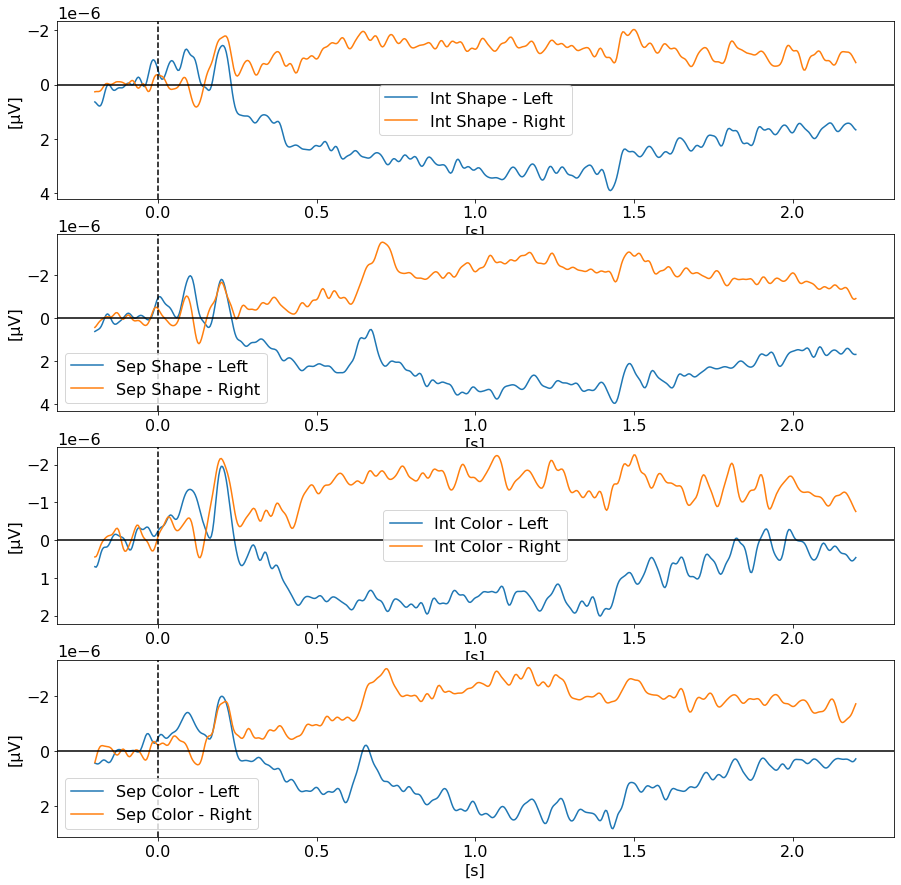

In [8]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(4, 1, figsize=(15,15))

# 2. Plot Figure #1
axs[0].plot(times, cda_all['Integrated_Shape']['left'].mean(0), label='Int Shape - Left')
axs[0].plot(times, cda_all['Integrated_Shape']['right'].mean(0), label='Int Shape - Right')
axs[0].axvline(x=0, color='k', linestyle='--')
axs[0].axhline(y=0, color='k', linestyle='-')
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_ylabel('[μV]')
axs[0].set_xlabel('[s]')

# 2. Plot Figure #2
axs[1].plot(times, cda_all['Separation_Shape']['left'].mean(0), label='Sep Shape - Left')
axs[1].plot(times, cda_all['Separation_Shape']['right'].mean(0), label='Sep Shape - Right')
axs[1].axvline(x=0, color='k', linestyle='--')
axs[1].axhline(y=0, color='k', linestyle='-')
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_ylabel('[μV]')
axs[1].set_xlabel('[s]')

# 2. Plot Figure #3
axs[2].plot(times, cda_all['Integrated_Color']['left'].mean(0), label='Int Color - Left')
axs[2].plot(times, cda_all['Integrated_Color']['right'].mean(0), label='Int Color - Right')
axs[2].axvline(x=0, color='k', linestyle='--')
axs[2].axhline(y=0, color='k', linestyle='-')
axs[2].invert_yaxis()
axs[2].legend()
axs[2].set_ylabel('[μV]')
axs[2].set_xlabel('[s]')

# 2. Plot Figure #4
axs[3].plot(times, cda_all['Separation_Color']['left'].mean(0), label='Sep Color - Left')
axs[3].plot(times, cda_all['Separation_Color']['right'].mean(0), label='Sep Color - Right')
axs[3].axvline(x=0, color='k', linestyle='--')
axs[3].axhline(y=0, color='k', linestyle='-')
axs[3].invert_yaxis()
axs[3].legend()
axs[3].set_ylabel('[μV]')
axs[3].set_xlabel('[s]')

#plt.savefig("./V-2018-Exp1_CDA-reprod.png", dpi=300, format='png')